# Results

The script below runs the model, outputs the results, and generates figures.

Last updated: 13 April 2020

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
os.chdir('..')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture

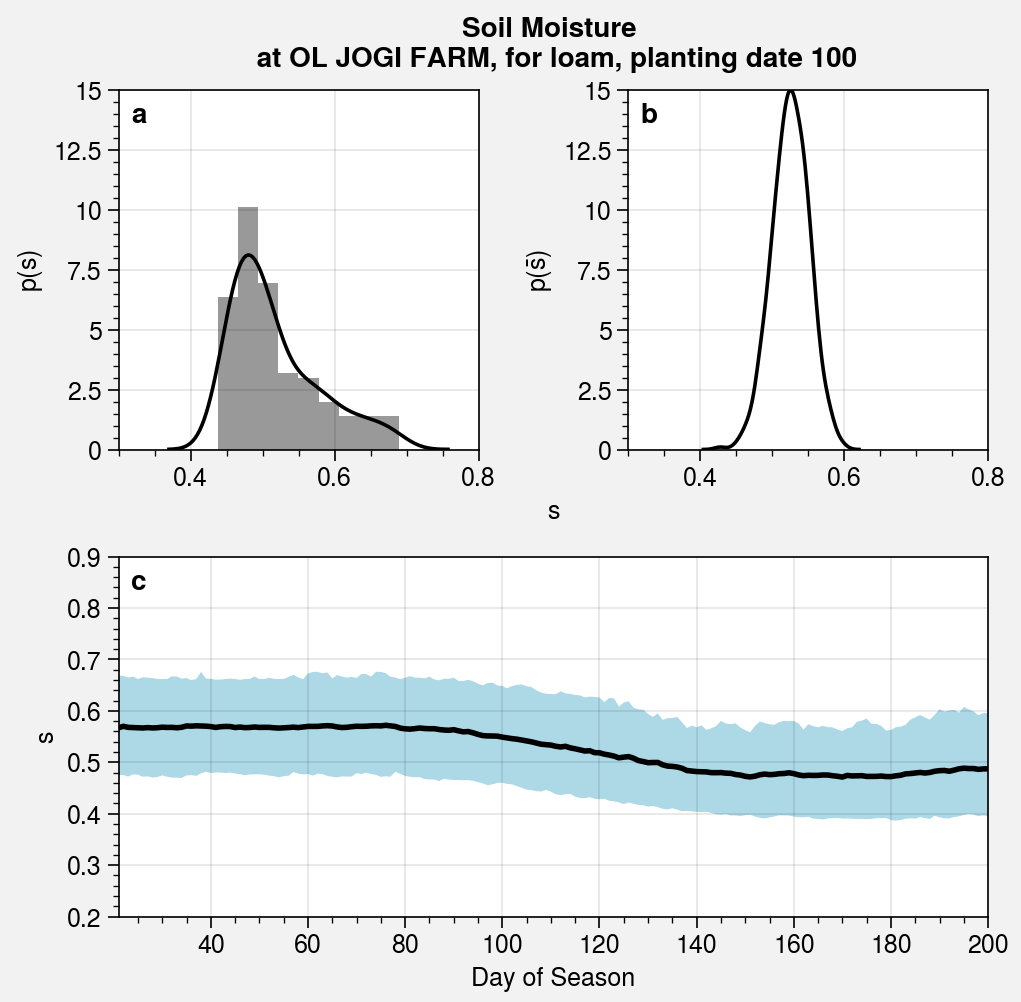

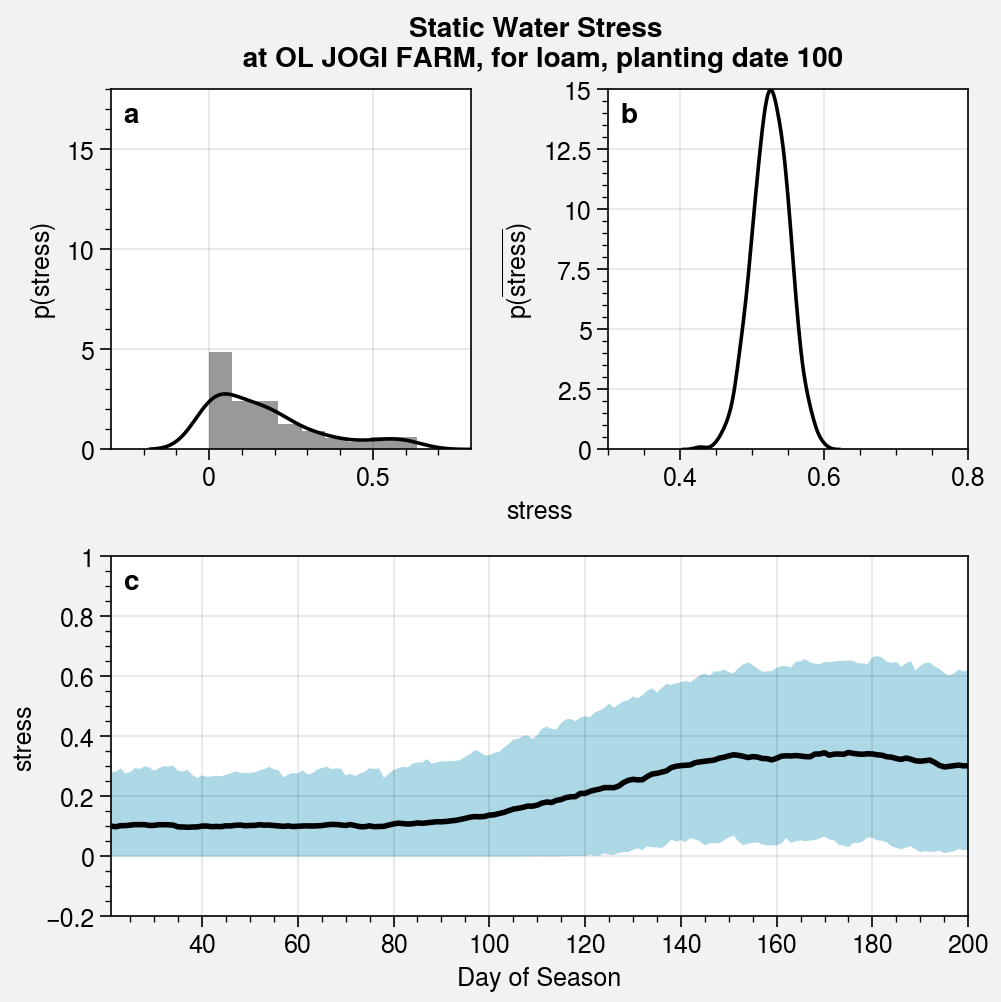

In [8]:
# Figs 1 and 2 using proplot

def soil_moisture_pdf(n_sim = 500, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = 21 
    end = start + lgp
    
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # SOIL MOISTURE
    # Part 6. Make figures: 
    # Complex grid
    array = [  # the "picture"; 1 == subplot a, 2 == subplot b, etc.
        [1, 1, 2, 2],
        [3, 3, 3, 3],
    ]
    f, axs = plot.subplots(array, axwidth=1.8, share=0, spanx=1, sharey=0)
    axs.format(
        abc=True, abcloc='ul', suptitle='Soil Moisture \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim,
        xlabel='s', ylabel='ylabel'
    )

    axs[0,0].format(ylabel=r'p($s$)')
    axs[0,1].format(ylabel=r'p($\bar{s}$)')
    
    # plot the soil moisture for just one simulation
    num_of_sim = 0
    s_sim = output[num_of_sim][start:end]['s']
    data = np.array(s_sim)
    ax = axs[0]
    sns.distplot(data, ax=ax, color='k', **{'kde': True, 'hist': True}) 
    ax.format(xlim=(0.3, 0.8), ylim=(0, 15))
    
    ax = axs[1]
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': False}) 
    ax.format(xlim=(0.3, 0.8), ylim=(0, 15))
    
    # plot avg s.m. from each day's s.m.
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
    avg_daily_t = avg_daily.T
    daily_mean = avg_daily.mean(axis=1)
    daily_mean = daily_mean
    data = np.array(daily_mean)
    
    axs[2].plot(daily_mean, color='k', lw=2) 
    axs[2].format(ylabel='test')
    plt.xlabel('Day of Season')

    x = np.arange(0+21, len(daily_mean)+21, 1) 

    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[2].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue')
    plt.ylim(0.2, 0.9)
    plt.ylabel('s')
    
    plt.show()
    
    # STATIC WATER STRESS
    # Complex grid
    array = [  # the "picture"; 1 == subplot a, 2 == subplot b, etc.
        [1, 1, 2, 2],
        [3, 3, 3, 3],
    ]
    f, axs = plot.subplots(array, axwidth=1.8, share=0, spanx=1, sharey=0)
    axs.format(
        abc=True, abcloc='ul', suptitle='Static Water Stress \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim,
        xlabel='stress', ylabel='ylabel'
    )

    axs[0,0].format(ylabel=r'p($stress$)')
    axs[0,1].format(ylabel=r'p($\overline{stress}$)')
    
    # fig a
    num_of_sim = 100
    s_sim = output[num_of_sim][start:end]['stress']
    data = np.array(s_sim)
    ax = axs[0]
    sns.distplot(data, ax=ax, color='k', **{'kde': True, 'hist': True})#.set(xlim=0) # bins=None,, label="lgp=%d" %lgp
    ax.format(xlim=(-0.3, 0.8), ylim=(0, 18))
    
    # fig b
    ax = axs[1]
    sns.distplot(avg_s, ax=ax, color='k', **{'kde': True, 'hist': False}) 
    ax.format(xlim=(0.3, 0.8), ylim=(0, 15))
    
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean = daily_mean
    
    axs[2].plot(daily_mean, color='k', lw=2)
    plt.xlabel('Day of Season')

    # fig c
    x = np.arange(0+21, len(daily_mean)+21, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[2].fill_between(x, quant[0.1], quant[0.9],facecolor='lightblue') 
    plt.ylim(-0.2, 1)
    plt.ylabel('stress')
    
    return int(lgp), avg_s, output, start, end

lgp, avg_s, output, start, end = soil_moisture_pdf()

Notes: How to bound the kde fit on static water stress to zero?
* [DataCamp](https://www.datacamp.com/community/tutorials/probability-distributions-python) article talks about distributions and exponential one still has curve that overflows to zero.
* [Stackoverflow](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python) says only option is to cut the axis limits to zero. Also [here](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python). Explanation for why you can get negative values from a positive density kernel density estimation, [stackexchange](https://stats.stackexchange.com/questions/109549/negative-density-for-non-negative-variables).